In [2]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
%matplotlib nbagg

In [3]:
file_name="EJ309_Co60_60s.h5"
data=h5py.File(file_name,"r")
event_data=data["event_data"]
gamma_raw_data=np.array(data["raw_data"])
gamma_raw_data=np.float32(gamma_raw_data)

In [58]:
np.shape(gamma_raw_data)

(154655, 1100)

In [4]:
file_name="EJ309_Ca252_60s.h5"
data=h5py.File(file_name,"r")
event_data=data["event_data"]
neutron_raw_data=np.array(data["raw_data"])
neutron_raw_data=np.float32(neutron_raw_data)

In [5]:
#take first 10000 events
gamma_data=gamma_raw_data[:]
neutron_data=neutron_raw_data[:]

In [6]:
baseline=np.mean(gamma_data[:,0:900],axis=1)
gamma_baseline_data=gamma_data-baseline[:,None]
gamma_baseline_data=gamma_baseline_data[:,950:1050]

In [7]:
baseline=np.mean(neutron_data[:,0:900],axis=1)
neutron_baseline_data=neutron_data-baseline[:,None]
neutron_baseline_data=neutron_baseline_data[:,950:1050]

In [8]:
print(np.shape(gamma_data))
print(np.shape(neutron_data))

(154655, 1100)
(1426283, 1100)


In [10]:
mask=np.max(gamma_baseline_data,axis=1)>100
gamma_threshold_data=gamma_baseline_data[mask]

mask=np.max(neutron_baseline_data,axis=1)>100
neutron_threshold_data=neutron_baseline_data[mask]

print(np.shape(gamma_threshold_data))
print(np.shape(neutron_threshold_data))

(154645, 100)
(1424236, 100)


<IPython.core.display.Javascript object>


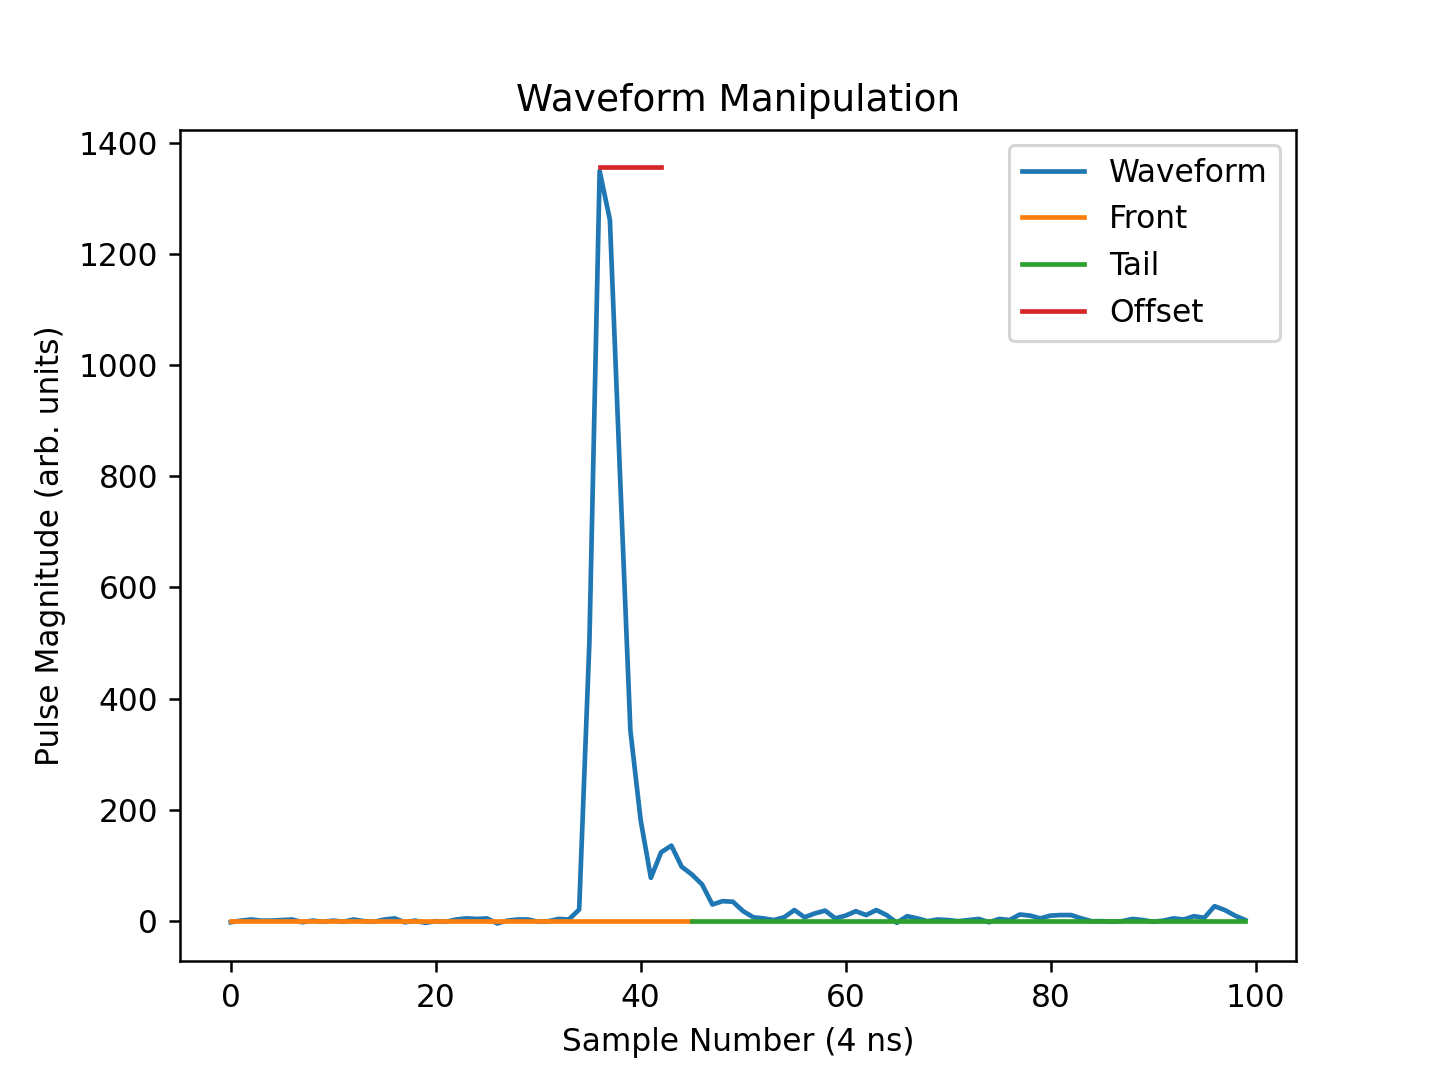

Text(0.5, 1.0, 'Waveform Manipulation')

In [13]:
plt.figure("PSD Waveforms")
for i in range(0,1):
    plt.plot(gamma_threshold_data[0])
    
plt.plot(np.zeros(46))
plt.plot(np.arange(45,100),np.zeros(55))
plt.plot(np.arange(36,43),1356*np.ones(7))
plt.legend(["Waveform","Front","Tail","Offset"])
plt.xlabel("Sample Number (4 ns)")
plt.ylabel("Pulse Magnitude (arb. units)")
plt.title("Waveform Manipulation")

<IPython.core.display.Javascript object>


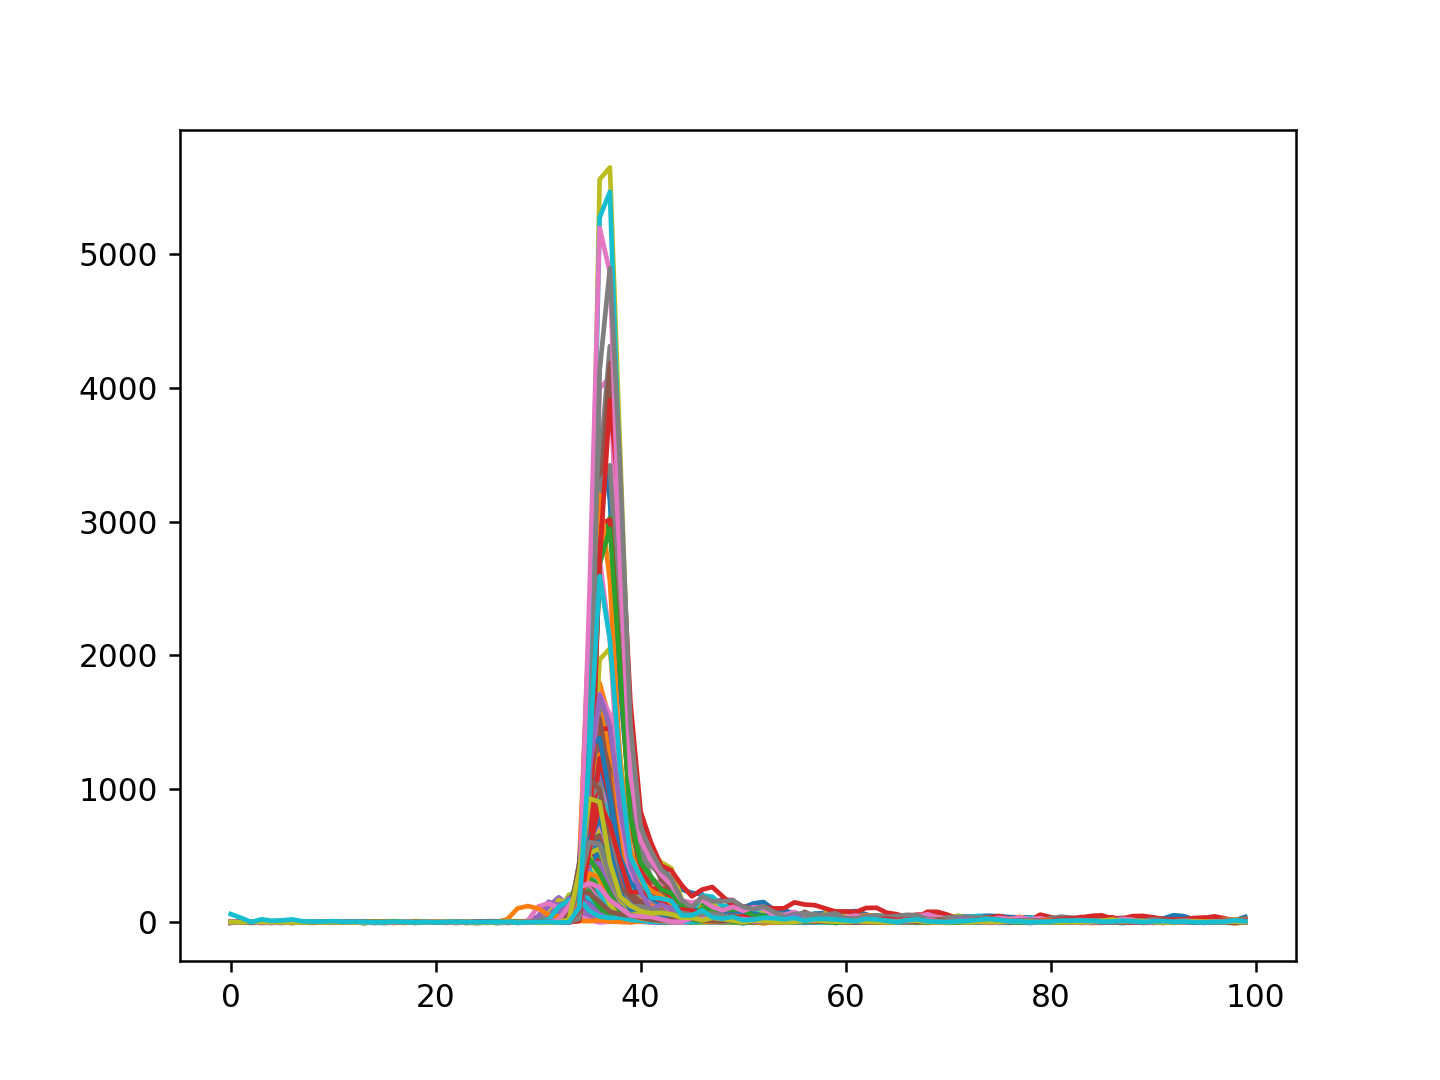

In [112]:
plt.figure("Neutron Waveforms")
for i in range(0,100):
    plt.plot(neutron_threshold_data[i])

<IPython.core.display.Javascript object>


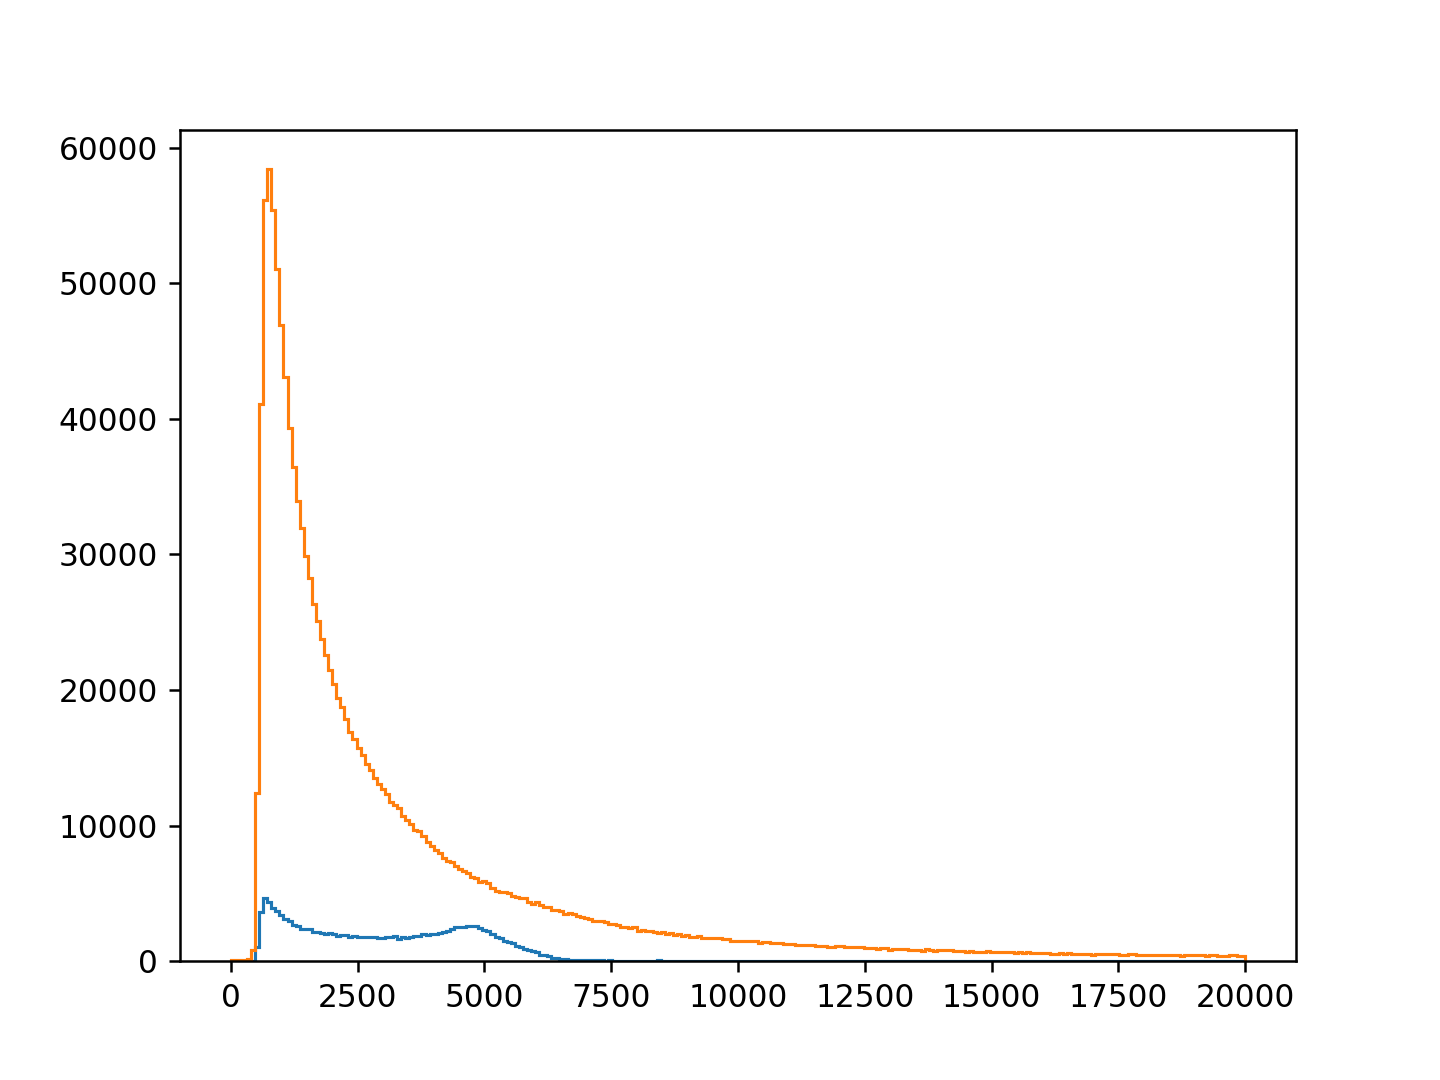

In [170]:
#spectra
plt.figure("Spectra")
gamma_histogram=plt.hist(np.sum(gamma_baseline_data,axis=1),bins=250,histtype='step',range=[0,20000])
gamma_hist_values=gamma_histogram[0]
gamma_hist_bins=gamma_histogram[1]
gamma_hist_bins=0.5*(gamma_hist_bins[1:]+gamma_hist_bins[:-1])
neutron_histogram=plt.hist(np.sum(neutron_baseline_data,axis=1),bins=250,histtype='step',range=[0,20000])
neutron_hist_values=neutron_histogram[0]
neutron_hist_bins=neutron_histogram[1]
neutron_hist_bins=0.5*(neutron_hist_bins[1:]+neutron_hist_bins[:-1])
plt.

<IPython.core.display.Javascript object>


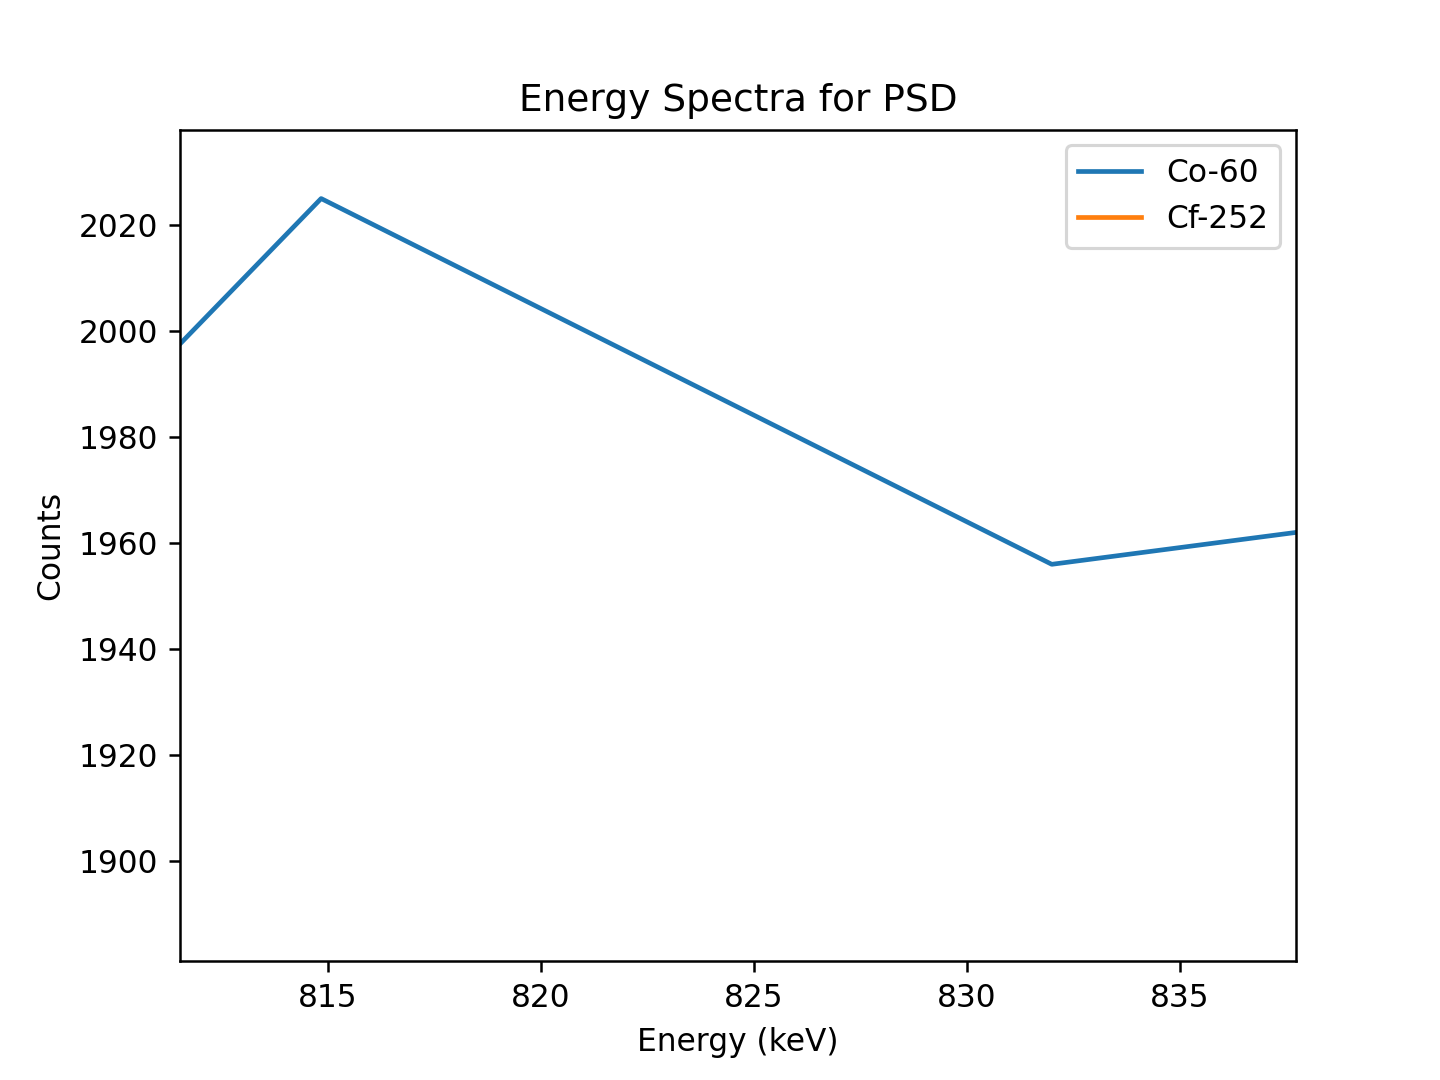

In [379]:
energy_calib=[0,1040]
channel_calib=[0,4850]
coeff=np.polyfit(channel_calib,energy_calib,1)

plt.figure("Energy Calibrated Spectrum")
gamma_hist_energies=gamma_hist_bins*coeff[0]+coeff[1]
plt.plot(gamma_hist_energies,gamma_hist_values)
neutron_hist_energies=neutron_hist_bins*coeff[0]+coeff[1]
plt.plot(neutron_hist_energies,neutron_hist_values)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Energy Spectra for PSD")
plt.legend(["Co-60","Cf-252"])

<IPython.core.display.Javascript object>


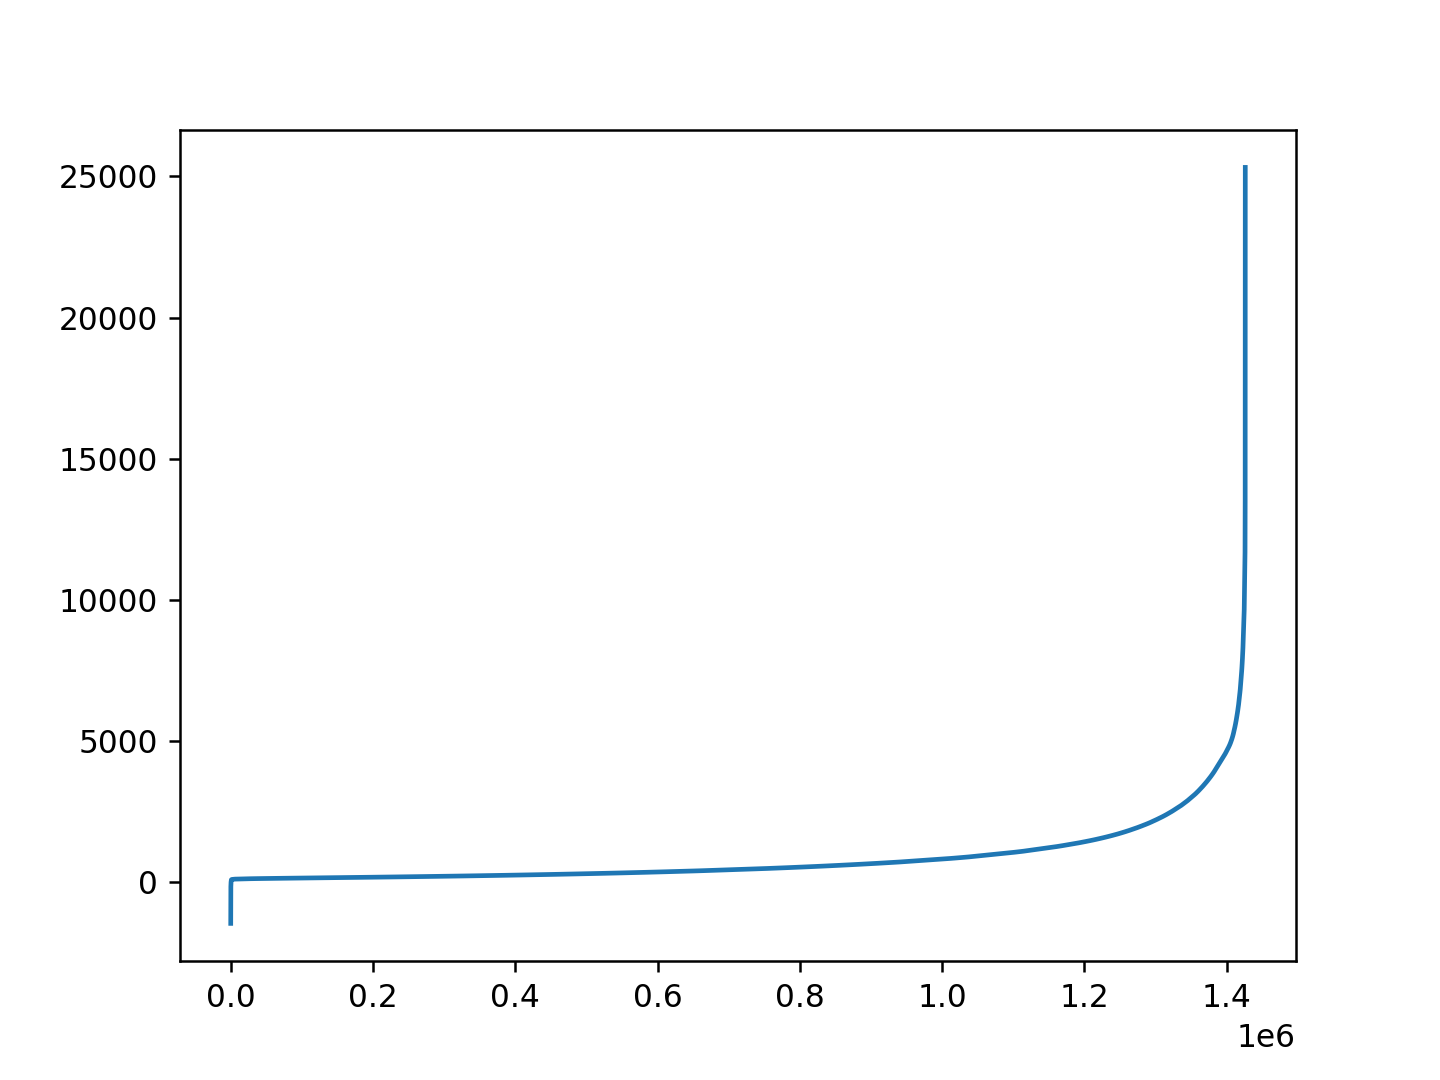

In [172]:
# convert waveform integrals to energy
gamma_waveform_channels=np.sum(gamma_baseline_data,axis=1)
gamma_waveform_energy=gamma_waveform_channels*coeff[0]+coeff[1]

neutron_waveform_channels=np.sum(neutron_baseline_data,axis=1)
neutron_waveform_energy=neutron_waveform_channels*coeff[0]+coeff[1]

#sort raw_data in order of ascending energy
gamma_sort_indices=np.argsort(gamma_waveform_energy)
gamma_waveform_energy=gamma_waveform_energy[gamma_sort_indices]

neutron_sort_indices=np.argsort(neutron_waveform_energy)
neutron_waveform_energy=neutron_waveform_energy[neutron_sort_indices]

#sort datasets
gamma_sorted_data=gamma_baseline_data[gamma_sort_indices]
neutron_sorted_data=neutron_baseline_data[neutron_sort_indices]

plt.figure("test")
plt.plot(neutron_waveform_energy)



(1580938, 100)
(1580938,)
(1580938,)


<IPython.core.display.Javascript object>


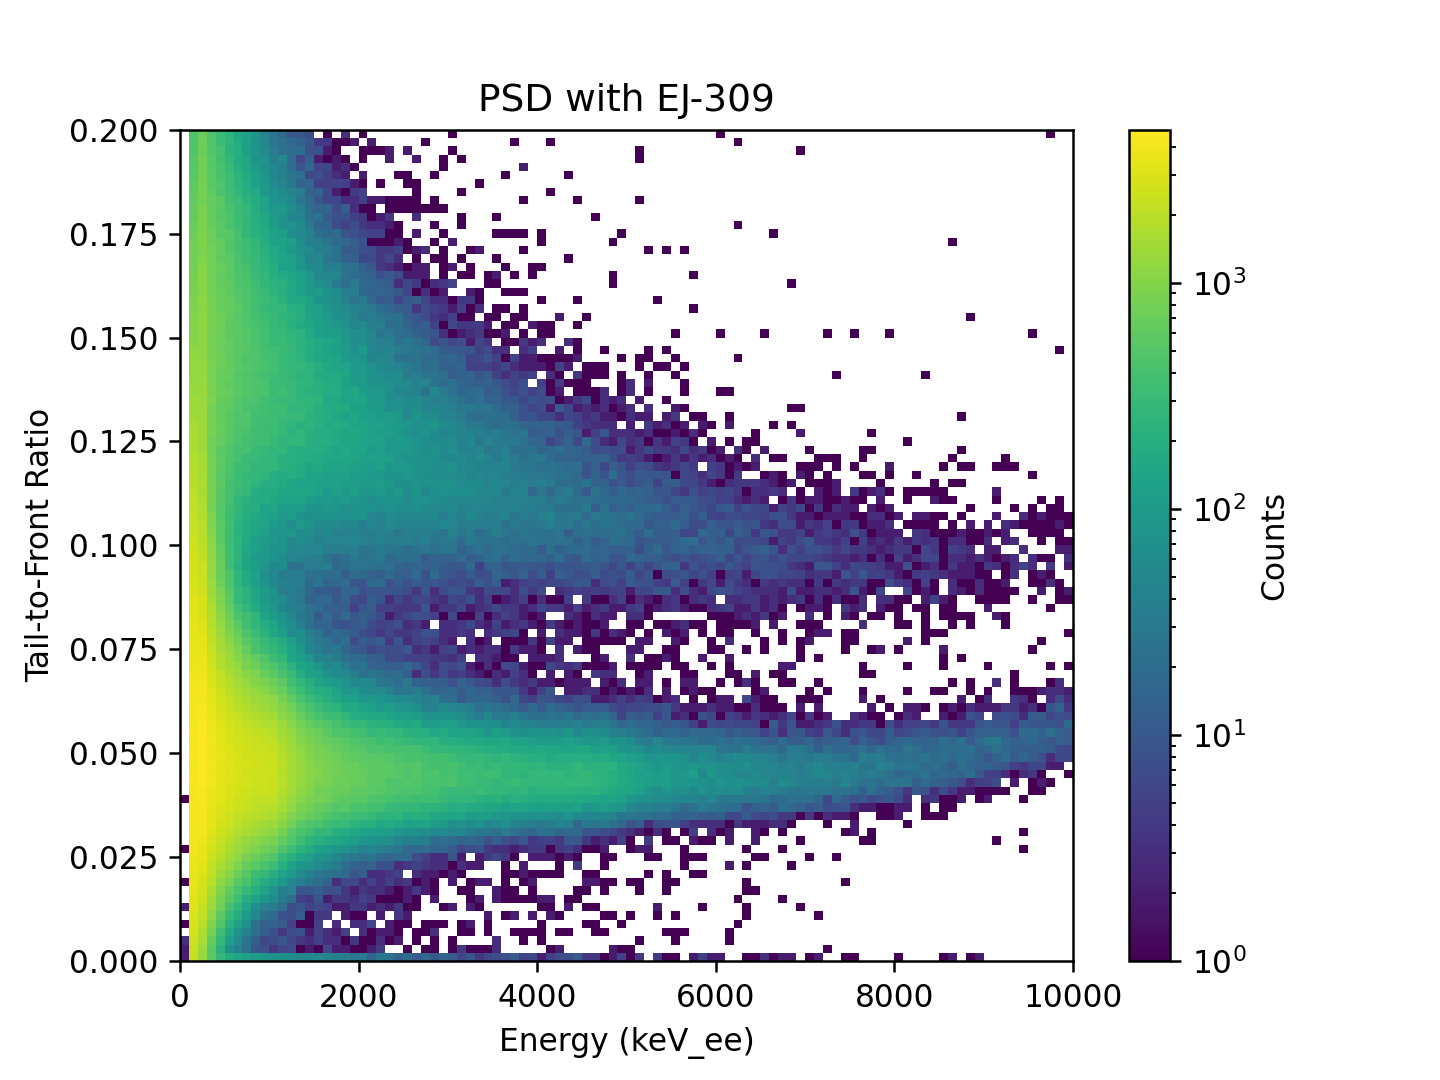

In [397]:
#define optimal offset for gaussian separation
offset=20

#get peak locations
gamma_peak_loc=np.argmax(gamma_sorted_data,axis=1)
neutron_peak_loc=np.argmax(neutron_sorted_data,axis=1)

#iterate through each energy bin and get peak gaussians
bin_width=(gamma_hist_energies[1]-gamma_hist_energies[0])/2

# for i in range(0,np.size(gamma_hist_energies)):
#     mask=np.abs(gamma_waveform_energy-gamma_hist_energies[i])<=bin_width
#     binned_gamma_waveforms=gamma_sorted_data[mask]
#     mask=np.abs(neutron_waveform_energy-gamma_hist_energies[i])<=bin_width
#     binned_neutron_waveforms=neutron_sorted_data[mask]
    
    
# #     if i==5:
# #         print(gamma_hist_energies[i])
# #         plt.figure("test2")
# #         #plt.plot(np.sum(binned_gamma_waveforms,axis=1)*coeff[0]+coeff[1])
# #         plt.plot(np.sum(binned_neutron_waveforms,axis=1)*coeff[0]+coeff[1])
#     if np.size(binned_gamma_waveforms)!=0 && np.size(binned_gamma_waveforms)!=0:
        
#     else:

combined_data=np.vstack([gamma_sorted_data,neutron_sorted_data])
combined_energy=np.hstack([gamma_waveform_energy,neutron_waveform_energy])
combined_peak_loc=np.hstack([gamma_peak_loc,neutron_peak_loc])
print(np.shape(combined_data))
print(np.shape(combined_energy))
print(np.shape(combined_peak_loc))
energy=[]
tail_peak_ratio=[]
for i in range(0,np.shape(combined_data)[0]):
    energy.append(combined_energy[i])
    waveform=combined_data[i]
    peak_integral=np.sum(waveform[0:combined_peak_loc[i]+offset])
    tail_integral=np.sum(waveform[combined_peak_loc[i]+offset:])
    tail_peak_ratio.append(tail_integral/peak_integral)
    
    

plt.figure("Ratio v. Energy")
ratio_histogram=plt.hist2d(energy,tail_peak_ratio,range=[[0,10000],[0,0.2]],bins=100,norm=colors.LogNorm())
cbar=plt.colorbar()
cbar.set_label("Counts")
plt.xlabel ("Energy (keV_ee)")
plt.ylabel("Tail-to-Front Ratio")
plt.title("PSD with EJ-309")

ratio_values=ratio_histogram[0]
xedges=ratio_histogram[1]
yedges=ratio_histogram[2]

<IPython.core.display.Javascript object>


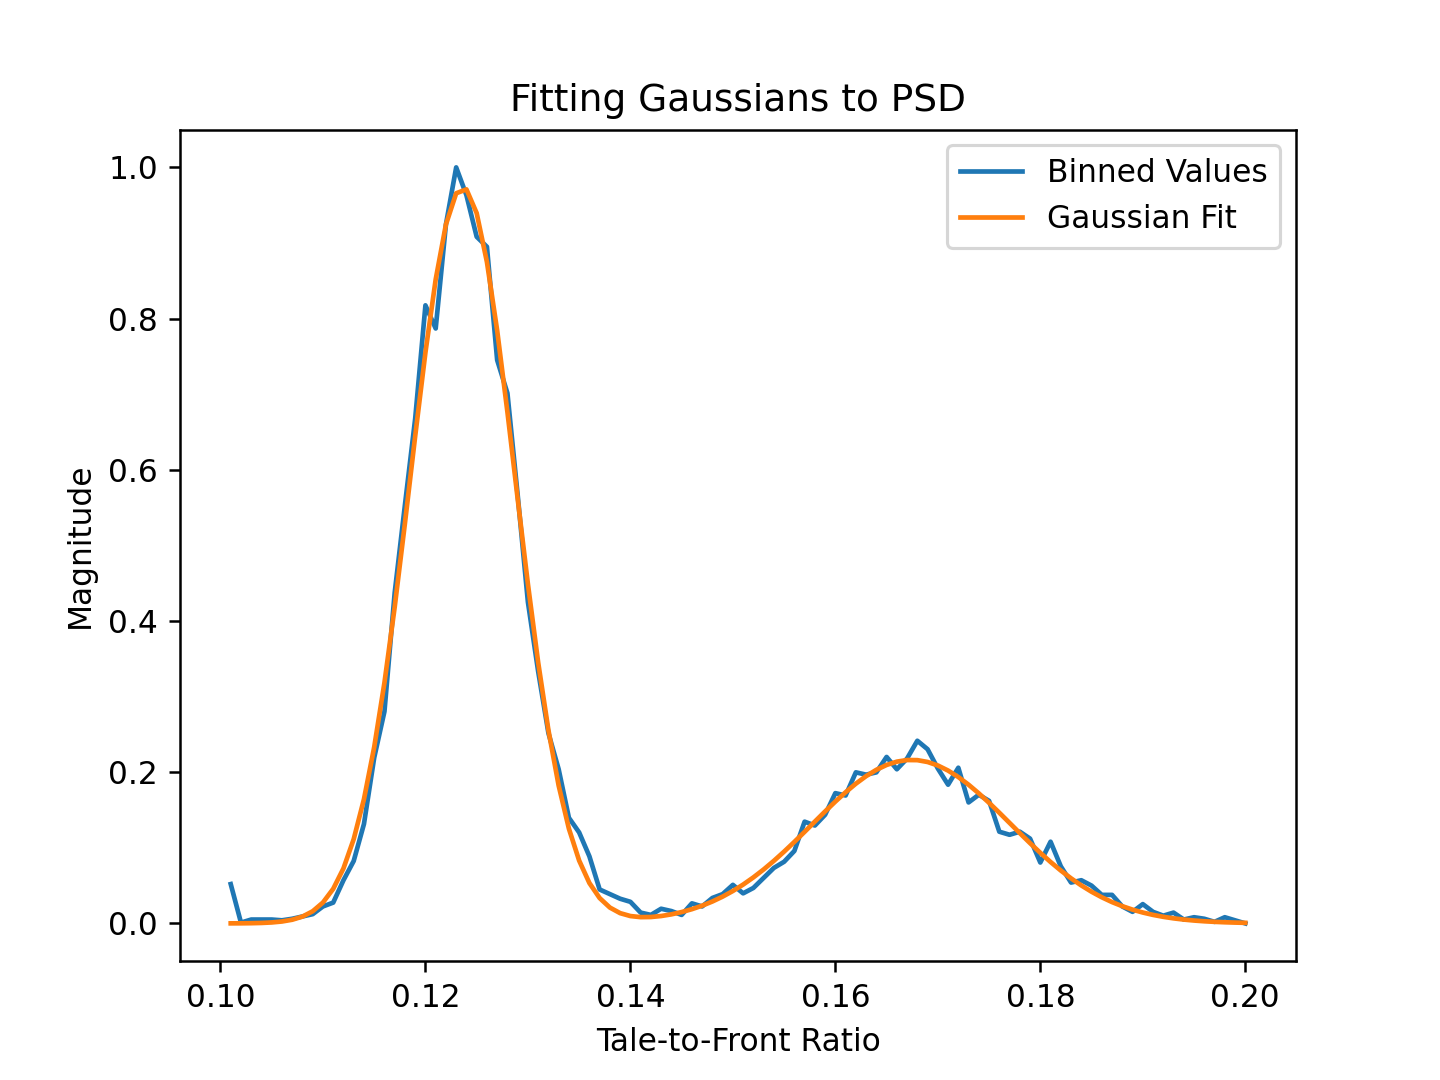

In [399]:
FoM=[]
ratio_bins=0.5*(yedges[1:]+yedges[-1:])
def gauss2(x,fwhm1,fwhm2,mu1,mu2,magnitude1,magnitude2):
    sigma1=fwhm1/2.355
    sigma2=fwhm2/2.355
    return magnitude1/(np.sqrt(2*np.pi)*sigma1)*np.exp(-0.5*(x-mu1)**2/sigma1**2)+magnitude2/(np.sqrt(2*np.pi)*sigma2)*np.exp(-0.5*(x-mu2)**2/sigma2**2)


for i in range(0,np.shape(ratio_values)[0]):
    distribution=ratio_values[i]
    distribution=distribution/np.max(distribution)
    
    #20 bounds (0.001,[0.04,0.04,0.2,0.2,1,1]), p0 [0.015,0.015,0.125,0.17,1,0.1]
    try:
        popt,_=curve_fit(gauss2,ratio_bins,distribution,p0=[0.015,0.015,0.125,0.17,1,0.1],bounds=(0.001,[0.04,0.04,0.2,0.2,1,1]))
        if i==15:
            plt.figure("Test fom")
            plt.plot(ratio_bins,distribution)
            plt.plot(ratio_bins,gauss2(ratio_bins,*popt))
            plt.xlabel("Tale-to-Front Ratio")
            plt.ylabel("Magnitude")
            plt.legend(["Binned Values","Gaussian Fit"])
            plt.title("Fitting Gaussians to PSD")
            
        
        cutoff=np.min(distribution)
        if gauss2(popt[2],*popt)<2*cutoff or gauss2(popt[3],*popt)<2*cutoff or popt[2]<0 or popt[3]<0:
            
            FoM.append(0)
        else:
            FoM.append(2*np.abs(popt[2]-popt[3])/(np.abs(popt[0])+np.abs(popt[1])))
            
    except:
        FoM.append(0)

<IPython.core.display.Javascript object>


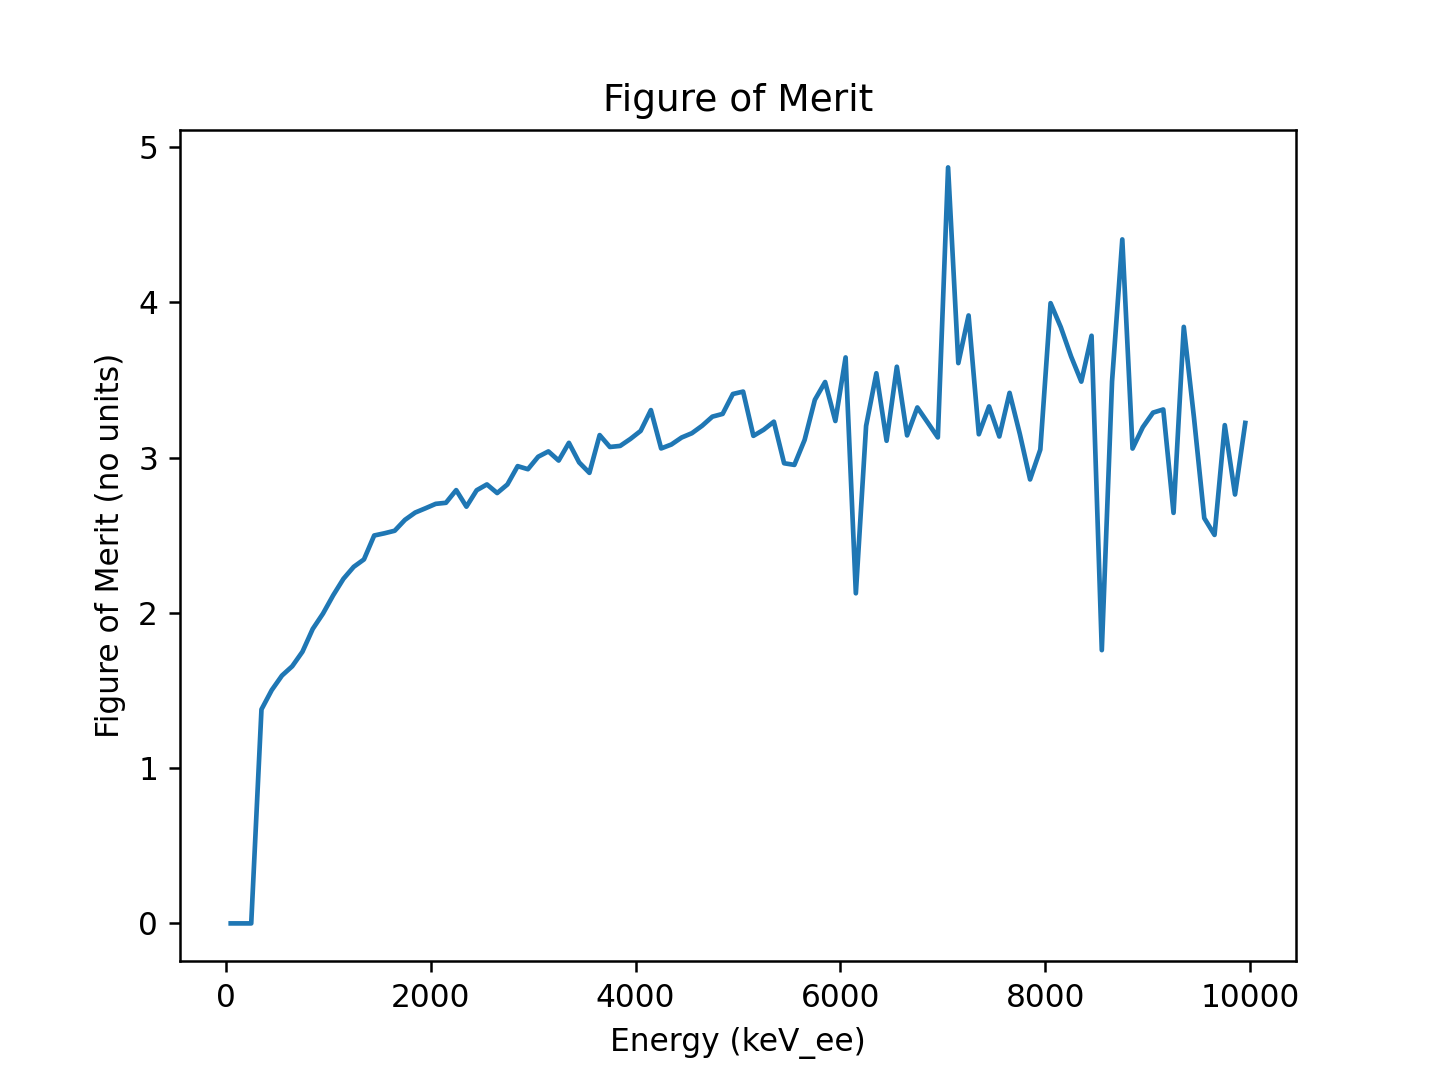

Text(0, 0.5, 'Figure of Merit (no units)')

In [400]:
FoM_energies=0.5*(xedges[1:]+xedges[:-1])
FoM[0]=0
FoM[1]=0

plt.figure("Figure of Merit")
plt.plot(FoM_energies,FoM)
plt.title("Figure of Merit")
plt.xlabel("Energy (keV_ee)")
plt.ylabel("Figure of Merit (no units)")


# def log_fit(x,base,magnitude,multiplier,constant2):
#     return magnitude*np.log((multiplier*x))+constant2
# popt,_=curve_fit(log_fit,FoM_energies,FoM)
# plt.plot(FoM_energies,log_fit(FoM_energies,*popt))



<IPython.core.display.Javascript object>


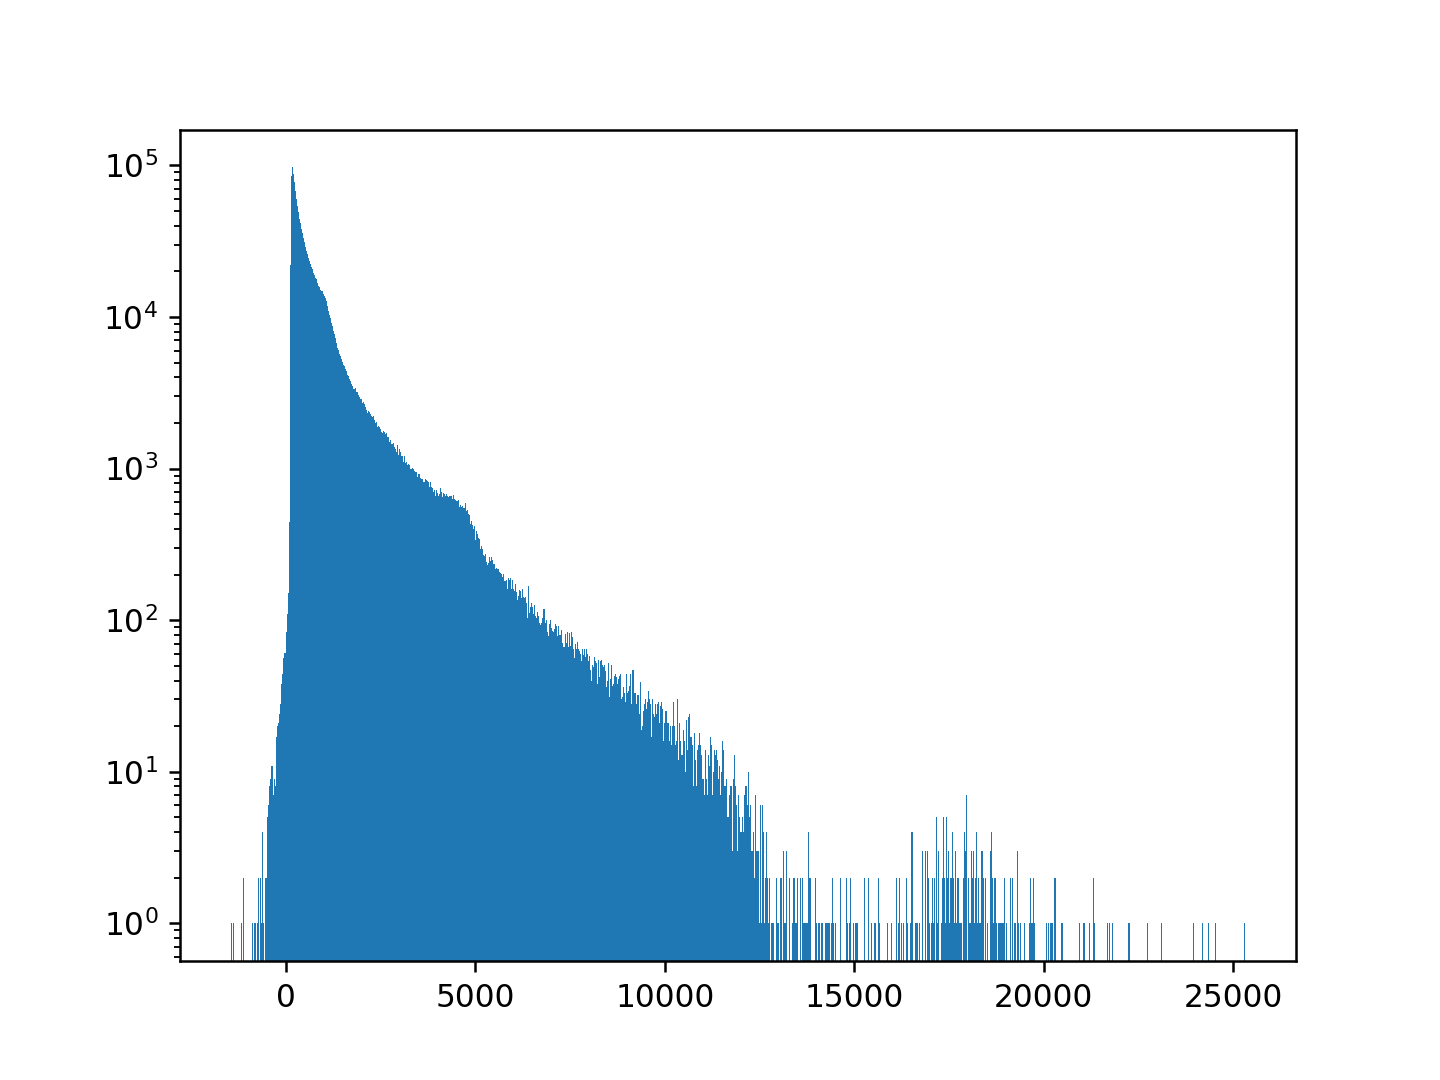

In [188]:
plt.figure("test energies")
plt.hist(energy,bins=1000)
plt.yscale("log")

In [ ]:
#iterate through each bin in histogram

<IPython.core.display.Javascript object>


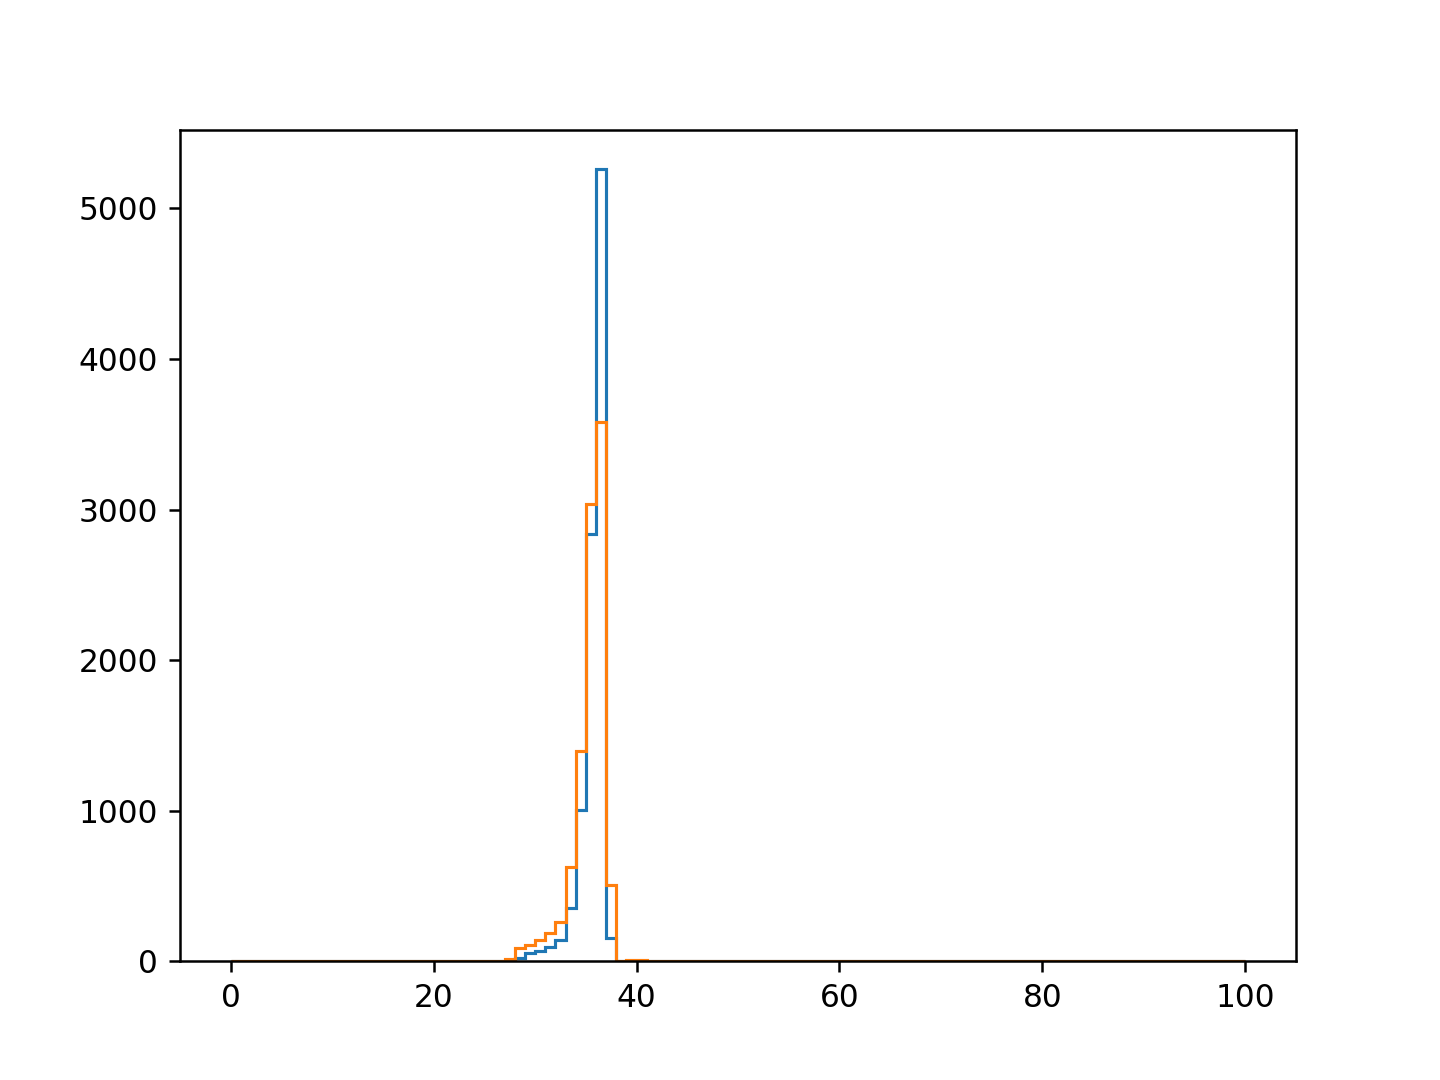

In [134]:
gamma_peak_locations=np.argmax(gamma_baseline_data,axis=1)
neutron_peak_locations=np.argmax(neutron_baseline_data,axis=1)
plt.figure("Gamma Peak Locations")
_=plt.hist(gamma_peak_locations,bins=100,range=[0,100],histtype='step')
_=plt.hist(neutron_peak_locations,bins=100,range=[0,100],histtype='step')

In [147]:
offset=5

In [148]:
#find area under waveforms before and after waveform peaks
gamma_ratios=[]
for i in range(0,100):
    before_peak=np.trapz(gamma_threshold_data[i][0:gamma_peak_locations[i]+offset])
    after_peak=np.trapz(gamma_threshold_data[i][gamma_peak_locations[i]+offset:])
    gamma_ratios.append(after_peak/before_peak)

In [149]:
neutron_ratios=[]
for i in range(0,100):
    before_peak=np.trapz(neutron_threshold_data[i][0:neutron_peak_locations[i]+offset])
    after_peak=np.trapz(neutron_threshold_data[i][neutron_peak_locations[i]+offset:])
    neutron_ratios.append(after_peak/before_peak)

<IPython.core.display.Javascript object>


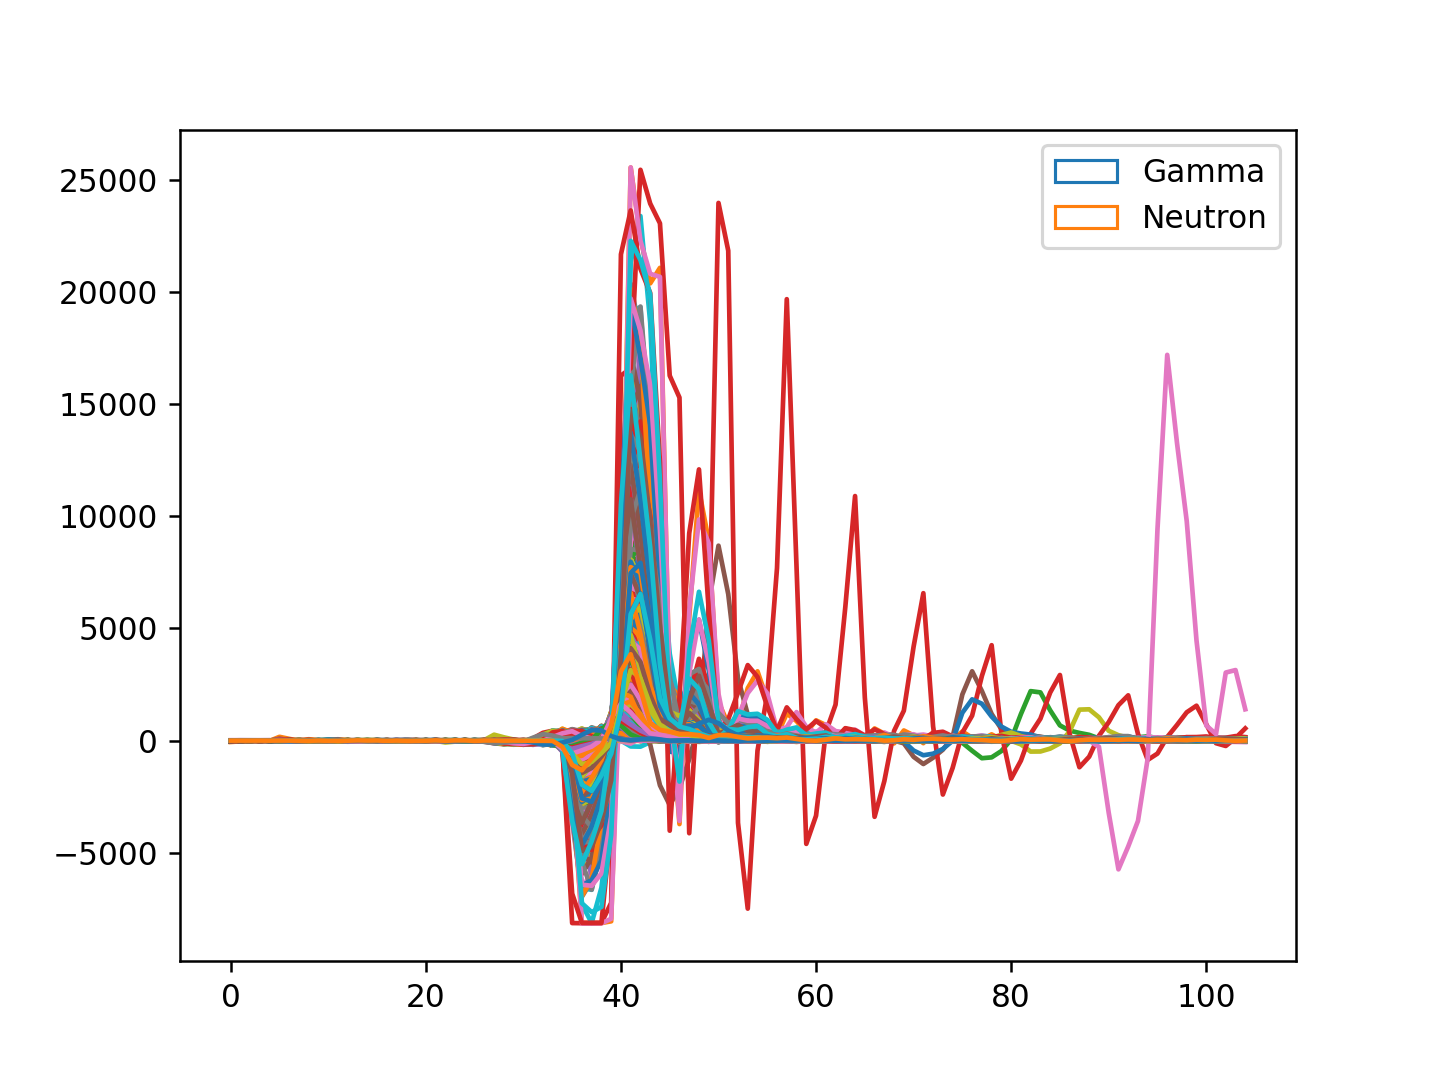

In [150]:
plt.figure("Ratio Comparisons")
_=plt.hist(gamma_ratios,bins=100,histtype='step',range=[0,1])
_=plt.hist(neutron_ratios,bins=100,histtype='step',range=[0,1])
plt.legend(["Gamma","Neutron"])

<IPython.core.display.Javascript object>


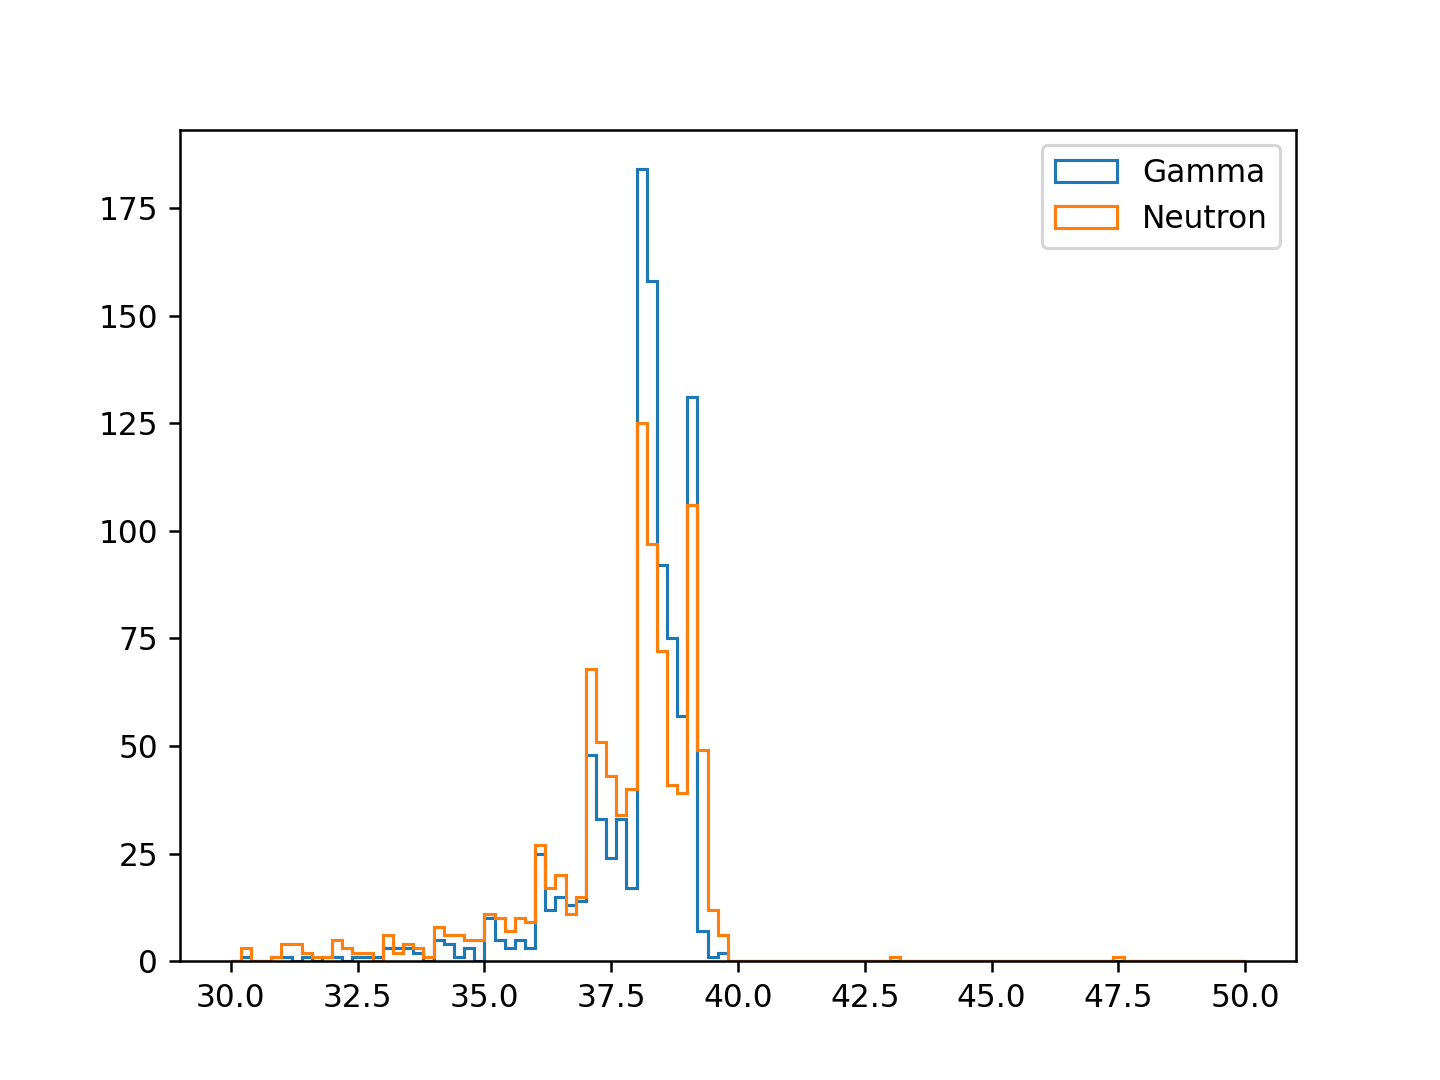

In [151]:
#constant fraction discrimination
delay=5
factor=3
gamma_waveform_peak_loc=[]

for i in range(0,1000):
    pulse=gamma_baseline_data[i]
    delay_zeros=np.zeros(delay)
    delayed_pulse=np.hstack([delay_zeros,pulse])*factor
    inverted_pulse=np.hstack(([pulse,delay_zeros]))*-1
    summed_pulse=np.add(inverted_pulse,delayed_pulse)
    plt.plot(summed_pulse)
    min_loc=np.argmin(summed_pulse)
    for j in range(min_loc,999999999999):
        if summed_pulse[j+1]>0:
            gamma_waveform_peak_loc.append(j+1/(1-summed_pulse[j+1]/summed_pulse[j]))
            break

neutron_waveform_peak_loc=[]
for i in range(0,1000):
    pulse=neutron_baseline_data[i]
    delay_zeros=np.zeros(delay)
    delayed_pulse=np.hstack([delay_zeros,pulse])*factor
    inverted_pulse=np.hstack(([pulse,delay_zeros]))*-1
    summed_pulse=np.add(inverted_pulse,delayed_pulse)
    plt.plot(summed_pulse)
    min_loc=np.argmin(summed_pulse)
    for j in range(min_loc,999999999999):
        if summed_pulse[j+1]>0:
            neutron_waveform_peak_loc.append(j+1/(1-summed_pulse[j+1]/summed_pulse[j]))
            break
            
plt.figure("CFD")
_=plt.hist(gamma_waveform_peak_loc,bins=100,histtype='step',range=[30,50])
_=plt.hist(neutron_waveform_peak_loc,bins=100,histtype='step',range=[30,50])
plt.legend(["Gamma","Neutron"])

<IPython.core.display.Javascript object>


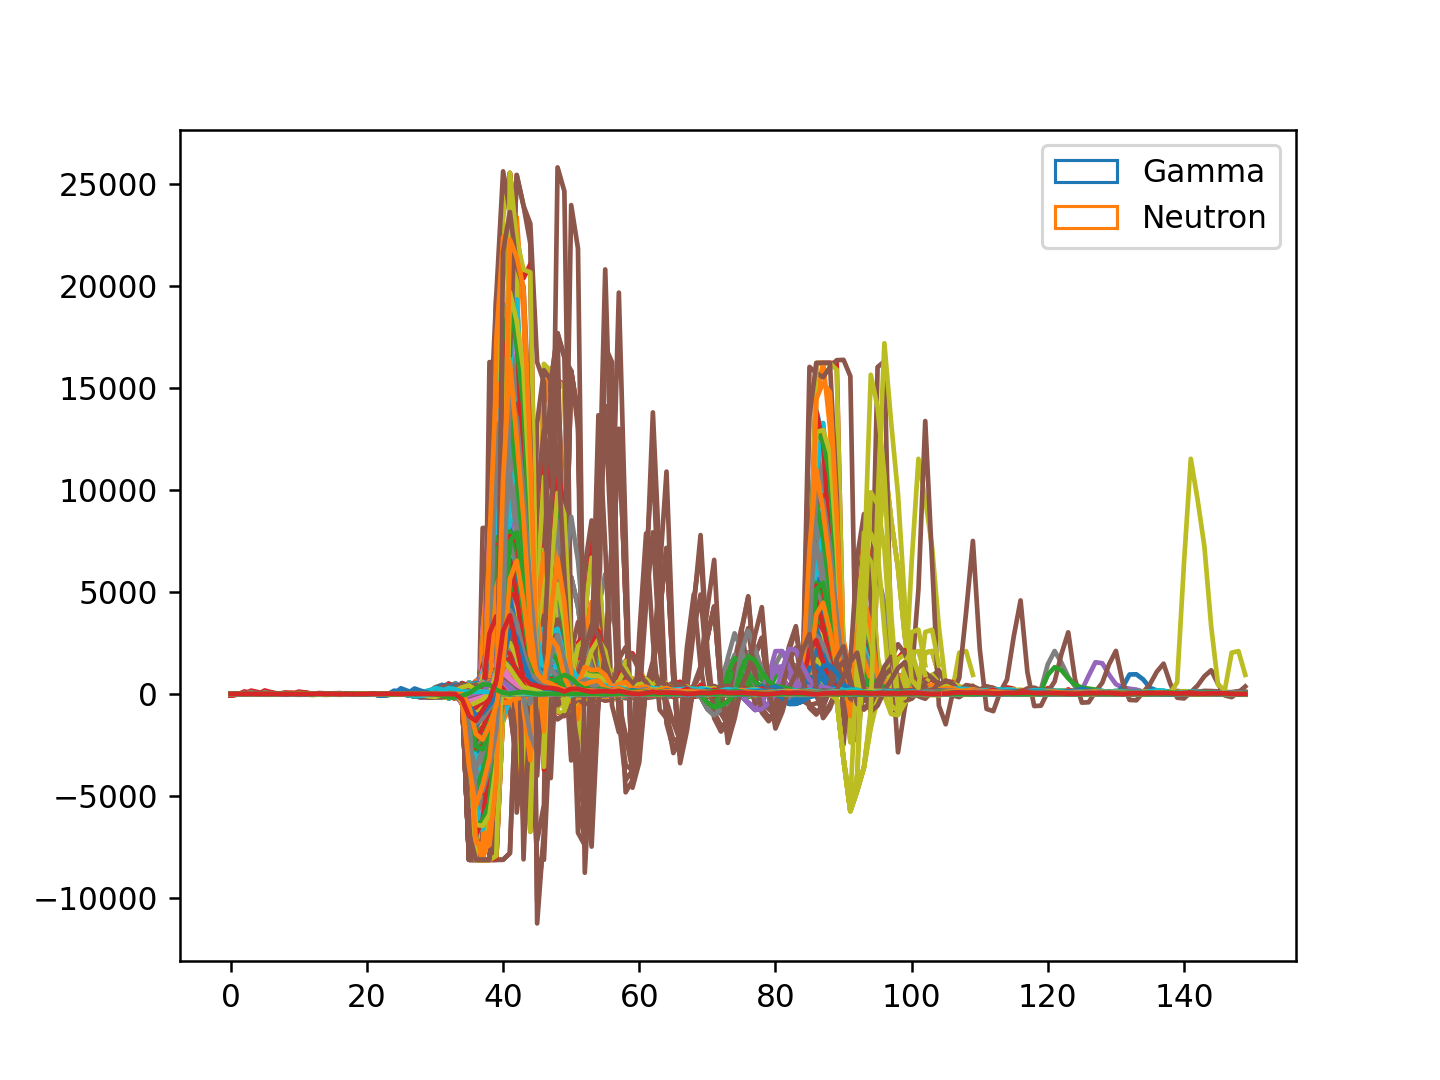

In [118]:
plt.figure("CFD Comparison")
_=plt.hist(gamma_waveform_peak_loc,bins=100,histtype='step',range=[0,100])
_=plt.hist(neutron_waveform_peak_loc,bins=100,histtype='step',range=[0,100])
plt.legend(["Gamma","Neutron"])

In [118]:
x=np.array([1,2,3,4,5,6])
mask=np.abs(3-x)<2
x[mask]

array([2, 3, 4])